In [14]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm catboost shap tensorflow --quiet


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import joblib


In [16]:
from google.colab import files
uploaded = files.upload()  # Upload CSV

df = pd.read_csv(list(uploaded.keys())[0])
df.head()


Saving data.csv to data.csv


,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,296.0,NaN,0.9483,13.0146,13.7235,36,07/01/2020,06/30/2023
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,151.0,NaN,0.9509,9.6899,10.1898,13,07/01/2020,06/30/2023
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,681.0,NaN,1.0597,21.5645,20.3495,151,07/01/2020,06/30/2023
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.9654,4.2680,4.4211,Too Few to Report,07/01/2020,06/30/2023
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,490.0,NaN,0.9715,16.1137,16.5863,77,07/01/2020,06/30/2023


In [17]:
df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
df.columns = ['col_' + col if col[0].isdigit() else col for col in df.columns]
print("Cleaned columns:", df.columns[:10])


Cleaned columns: Index(['Facility_Name', 'Facility_ID', 'State', 'Measure_Name',
       'Number_of_Discharges', 'Footnote', 'Excess_Readmission_Ratio',
       'Predicted_Readmission_Rate', 'Expected_Readmission_Rate',
       'Number_of_Readmissions'],
      dtype='object')


In [18]:
# Drop columns with >50% missing
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# Fill numeric
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [19]:
df['High_Readmission'] = (df['Predicted_Readmission_Rate'] > df['Predicted_Readmission_Rate'].median()).astype(int)

df_encoded = pd.get_dummies(df, drop_first=True)

X = df_encoded.drop(columns=['High_Readmission'])
y = df_encoded['High_Readmission']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [20]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
models = {
    "XGB": XGBClassifier(
        n_estimators=600, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1, eval_metric="logloss", tree_method="hist"
    ),
    "LGBM": LGBMClassifier(
        n_estimators=800, num_leaves=63, learning_rate=0.03,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1
    ),
    "CAT": CatBoostClassifier(
        depth=6, learning_rate=0.05, iterations=800,
        l2_leaf_reg=3.0, loss_function='Logloss',
        verbose=False, random_seed=42
    ),
}

# Clean column names for LightGBM compatibility
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

for name, clf in models.items():
    clf.fit(X_train, y_train)
    proba = clf.predict_proba(X_test)[:,1]
    preds = (proba >= 0.5).astype(int)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, preds, digits=4))
    print("ROC-AUC:", roc_auc_score(y_test, proba))


=== XGB ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2509
           1     1.0000    1.0000    1.0000      1193

    accuracy                         1.0000      3702
   macro avg     1.0000    1.0000    1.0000      3702
weighted avg     1.0000    1.0000    1.0000      3702

ROC-AUC: 1.0
[LightGBM] [Info] Number of positive: 4770, number of negative: 10038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 14808, number of used features: 137
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322123 -> initscore=-0.744032
[LightGBM] [Info] Start training from score -0.744032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [22]:
base_learners = [
    ("lr", LogisticRegression(max_iter=1000)),
    ("rf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)),
    ("xgb", XGBClassifier(
        n_estimators=600, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42, n_jobs=-1, eval_metric="logloss", tree_method="hist"
    ))
]

stack = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=1000),
    stack_method="predict_proba",
    n_jobs=-1
)
stack.fit(X_train, y_train)
proba_stack = stack.predict_proba(X_test)[:,1]
preds_stack = (proba_stack >= 0.5).astype(int)
print(classification_report(y_test, preds_stack, digits=4))
print("Stack ROC-AUC:", roc_auc_score(y_test, proba_stack))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2509
           1     1.0000    1.0000    1.0000      1193

    accuracy                         1.0000      3702
   macro avg     1.0000    1.0000    1.0000      3702
weighted avg     1.0000    1.0000    1.0000      3702

Stack ROC-AUC: 1.0


In [23]:
prec, rec, thr = precision_recall_curve(y_test, proba_stack)
f1_scores = 2*(prec*rec)/(prec+rec+1e-9)
best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx]
print(f"Best Threshold: {best_thr:.3f}, F1={f1_scores[best_idx]:.3f}")
y_opt = (proba_stack >= best_thr).astype(int)
print(classification_report(y_test, y_opt, digits=4))


Best Threshold: 0.921, F1=1.000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2509
           1     1.0000    1.0000    1.0000      1193

    accuracy                         1.0000      3702
   macro avg     1.0000    1.0000    1.0000      3702
weighted avg     1.0000    1.0000    1.0000      3702



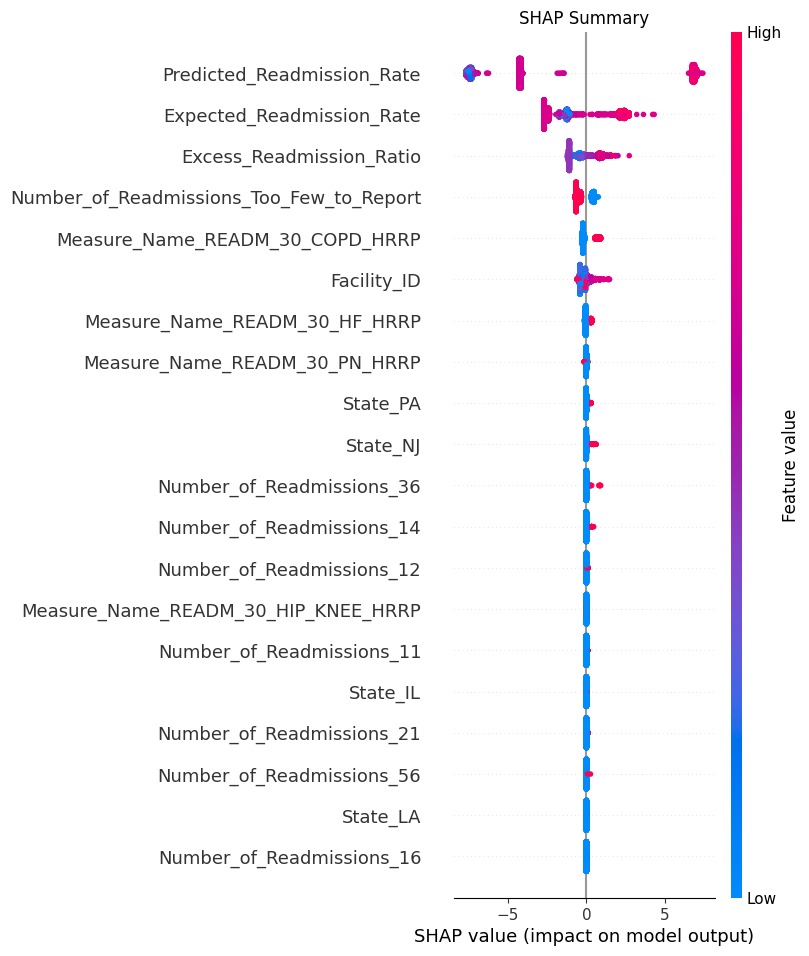

In [24]:
explainer = shap.TreeExplainer(models["XGB"])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary")
plt.show()


In [25]:
joblib.dump(models["XGB"], "best_readmission_model.pkl")
joblib.dump(scaler, "scaler_for_nn.pkl")
print("Models saved for future inference!")


Models saved for future inference!
